In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set_theme()

In [2]:
#bring in player data
player_data = 'players.csv'
player_df = pd.read_csv(player_data)
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732 entries, 0 to 2731
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nflId        2732 non-null   int64 
 1   height       2732 non-null   object
 2   weight       2732 non-null   int64 
 3   birthDate    2715 non-null   object
 4   collegeName  2724 non-null   object
 5   Position     2732 non-null   object
 6   displayName  2732 non-null   object
dtypes: int64(2), object(5)
memory usage: 149.5+ KB


In [3]:
#create dataframe for kickers only
kickers = ['K']
kicker_df = player_df[player_df['Position'].isin(kickers)]
kicker_df['Position'].value_counts()

K    57
Name: Position, dtype: int64

In [4]:
#bring in plays data (every nfl play with a kick involved)
play_data = 'plays.csv'
play_df = pd.read_csv(play_data)
#play_df.info()

Text(0.5, 1.0, 'NFL Special Teams Play Type')

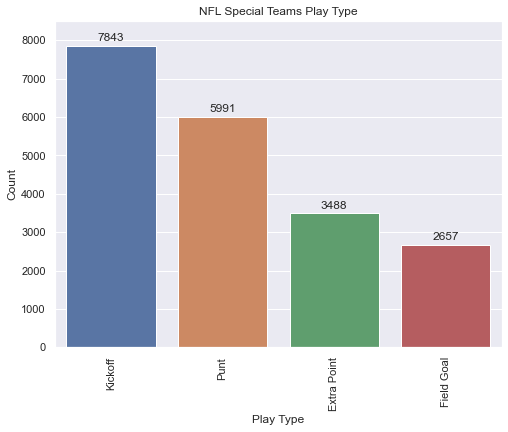

In [5]:
special_teams_play_count = play_df['specialTeamsPlayType'].value_counts().reset_index()
special_teams_play_count.columns = ['specialTeamsPlayType', 'playCount']

plt.figure(figsize = (8, 6))

plots = sns.barplot(x = 'specialTeamsPlayType', y = 'playCount', data = special_teams_play_count)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.0f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha = 'center', va = 'center',
                  size = 12, xytext = (0, 8),
                  textcoords = 'offset points')

plt.ylabel('Count')
plt.xlabel('Play Type')
plt.ylim(0, 8500)
plt.xticks(rotation = 90)
plt.title('NFL Special Teams Play Type')

19979


Text(0.5, 1.0, 'NFL Special Teams Play Type')

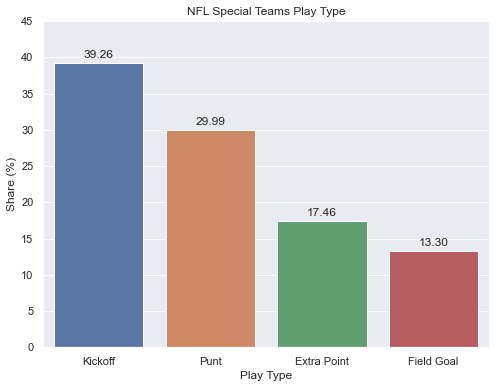

In [6]:
total_kicks = special_teams_play_count['playCount'].sum()
print(total_kicks)
def kick_share(row):
    if row['playCount'] > 0 :
        return round((row['playCount'] / total_kicks), 4) * 100
    
special_teams_play_count['kick_share'] = special_teams_play_count.apply(lambda row: kick_share(row), axis = 1)
special_teams_play_count.head()

plt.figure(figsize = (8, 6))

plots = sns.barplot(x = 'specialTeamsPlayType', y = 'kick_share', data = special_teams_play_count)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.2f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha = 'center', va = 'center',
                  size = 12, xytext = (0, 8),
                  textcoords = 'offset points')

plt.ylabel('Share (%)')
plt.xlabel('Play Type')
#plt.xticks(rotation = 90)
plt.ylim(0, 45)
plt.title('NFL Special Teams Play Type')

In [7]:
#join player and play data together 
kicker_fg_df = pd.merge(kicker_df, play_df, left_on = 'nflId', right_on = 'kickerId', how = 'inner')


In [8]:
#filter for only fg (and extra point) data
fg_attempt = ['Field Goal', 'Extra Point']
kicker_fg_df = kicker_fg_df[kicker_fg_df['specialTeamsPlayType'].isin(fg_attempt)]

In [9]:
#create field goal (extra point) distance variable
def field_goal_distance(row):
    if row['specialTeamsPlayType'] == 'Field Goal' :
        if row['specialTeamsResult'] == 'Kick Attempt Good' :
            return row['kickLength']
        if row['specialTeamsResult'] == 'Kick Attempt No Good' :
            return row['kickLength']
        if row['specialTeamsResult'] == 'Blocked Kick Attempt' :
            if row['absoluteYardlineNumber'] > 50 :
                return 128 - row['absoluteYardlineNumber'] 
            if row['absoluteYardlineNumber'] <= 50 :
                return row['absoluteYardlineNumber'] + 8
    if row['specialTeamsPlayType'] == 'Extra Point' :
        return 33
    
kicker_fg_df['field_goal_distance'] = kicker_fg_df.apply(lambda row: field_goal_distance(row), axis = 1)

In [10]:
#add a 1 for each field goal attempt (sum attempts)
def field_goal_attempt(row):
    if row['field_goal_distance'] > 0:
        return 1
        
kicker_fg_df['field_goal_attempt'] = kicker_fg_df.apply(lambda row: field_goal_attempt(row), axis = 1)

In [11]:
#add a 1 for each made field goal
def field_goal_made(row):
    if row['specialTeamsResult'] == 'Kick Attempt Good':
        return 1
        
kicker_fg_df['field_goal_made'] = kicker_fg_df.apply(lambda row: field_goal_made(row), axis = 1)

In [12]:
kicker_fg_df['field_goal_attempt'].value_counts()
#kicker_fg_df.info()
fg_only_df = kicker_fg_df
ep_only_df = kicker_fg_df

In [13]:
fg_only = ['Field Goal']
fg_only_df = fg_only_df[fg_only_df['specialTeamsPlayType'].isin(fg_only)]

In [ ]:
ep_only = ['Extra Point']
ep_only_df = ep_only_df[ep_only_df['specialTeamsPlayType'].isin(ep_only)]
ep_only_df = ep_only_df.drop(ep_only_df[ep_only_df.specialTeamsResult == 'Non-Special Teams Result'].index)

In [15]:
#create new dataframe and group by kicker, count total kicks and made field goals
fg_perc_df = kicker_fg_df.groupby(['nflId', 'displayName'])[['field_goal_attempt', 'field_goal_made']].sum().reset_index()

fg_perc_df.head()
#fg_perc_df.info()

,nflId,displayName,field_goal_attempt,field_goal_made
0,21213,Adam Vinatieri,122.0,103.0
1,23860,Phil Dawson,23.0,20.0
2,25326,Sebastian Janikowski,71.0,64.0
3,27091,Matt Bryant,84.0,75.0
4,29874,Mike Nugent,47.0,41.0


In [16]:
fg_perc_df['fieldGoalPercentage'] = (fg_perc_df.field_goal_made / fg_perc_df.field_goal_attempt)

In [17]:
#Average field goals attempted (limit sample size for charts)
fga_avg = sum(fg_perc_df.field_goal_attempt) / len(fg_perc_df.field_goal_attempt)
fga_avg = round(fga_avg, 2)

In [18]:
print('Average number of field goals attempted: ', fga_avg)

Average number of field goals attempted:  107.0


In [19]:
#change name of df to eliminate the sample changing for calculating the average
fg_perc_df1 = fg_perc_df[(fg_perc_df.field_goal_attempt >= fga_avg)]


In [20]:
fg_perc_df1 = fg_perc_df1.sort_values(by = ['field_goal_made'], ascending = False).reset_index(drop = True)

(0.75, 1.0)

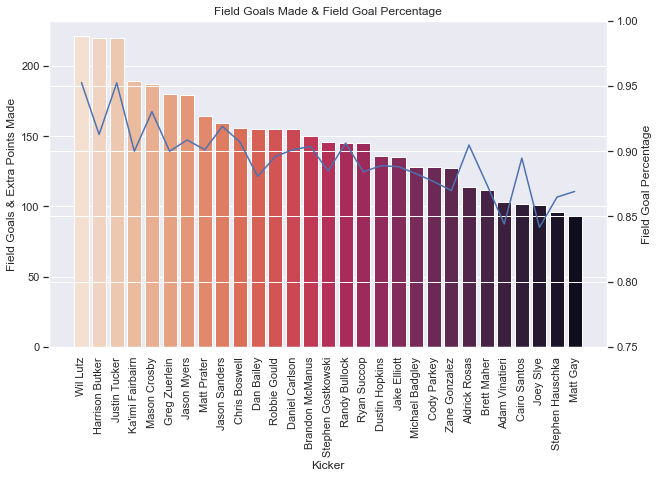

In [21]:
#Create combo chart (field goals made = bars, field goal % = line)
fig, ax1 = plt.subplots(figsize=(10,6))

#bar
ax1 = sns.barplot(x = 'displayName', y = 'field_goal_made', data = fg_perc_df1, palette = 'rocket_r')
ax1.set_title('Field Goals Made & Field Goal Percentage')
ax1.set_xlabel('Kicker')
ax1.set_ylabel('Field Goals & Extra Points Made')
plt.xticks(rotation = 90)

ax2 = ax1.twinx() #secondary axis for line

#line
ax2 = sns.lineplot(x= 'displayName', y = 'fieldGoalPercentage', data = fg_perc_df1, sort = False)
ax2.set_ylabel('Field Goal Percentage')
ax2.set_ylim(bottom = .75, top = 1)

In [22]:
#join player and play data together 
kicker_fg_adv_df = pd.merge(kicker_df, play_df, left_on = 'nflId', right_on = 'kickerId', how = 'inner')
#kicker_fg_adv_df.info()
#kicker_fg_adv_df.head()

In [23]:
#filter for only fg data
fg_attempt2 = ['Field Goal']
kicker_fg_adv_df = kicker_fg_adv_df[kicker_fg_adv_df['specialTeamsPlayType'].isin(fg_attempt2)]

In [24]:
#remove outliers
kicker_fg_adv_df['specialTeamsResult'].value_counts()

fg_outcomes = ['Kick Attempt Good', 'Kick Attempt No Good', 'Blocked Kick Attempt']
kicker_fg_adv_df = kicker_fg_adv_df[kicker_fg_adv_df['specialTeamsResult'].isin(fg_outcomes)]
#kicker_fg_adv_df.head()

In [25]:
kicker_fg_adv_df['specialTeamsResult'].value_counts()

Kick Attempt Good       2212
Kick Attempt No Good     384
Blocked Kick Attempt      37
Name: specialTeamsResult, dtype: int64

In [26]:
#add columns to new adv kicker df
def field_goal_blocked(row):
    if row['specialTeamsResult'] == 'Blocked Kick Attempt':
        return 1

kicker_fg_adv_df['field_goal_blocked'] = kicker_fg_adv_df.apply(lambda row: field_goal_blocked(row), axis = 1)    
kicker_fg_adv_df['field_goal_distance'] = kicker_fg_adv_df.apply(lambda row: field_goal_distance(row), axis = 1)
kicker_fg_adv_df['field_goal_attempt'] = kicker_fg_adv_df.apply(lambda row: field_goal_attempt(row), axis = 1)
kicker_fg_adv_df['field_goal_made'] = kicker_fg_adv_df.apply(lambda row: field_goal_made(row), axis = 1)

#kicker_fg_adv_df.info()

In [27]:
#create column for kick distance ranges
def kick_distance_range(row) :
    if row['field_goal_distance'] > 0 :
        if row['field_goal_distance'] <= 10:
            return '0 - 10'
        if row['field_goal_distance'] <= 20:
            return '11 - 20'
        if row['field_goal_distance'] <= 30:
            return '21 - 30'
        if row['field_goal_distance'] <= 40:
            return '31 - 40'
        if row['field_goal_distance'] <= 50:
            return '41 - 50'
        if row['field_goal_distance'] <= 60:
            return '51 - 60'
        if row['field_goal_distance'] > 60:
            return '60+'
        
kicker_fg_adv_df['kick_distance_range'] = kicker_fg_adv_df.apply(lambda row: kick_distance_range(row), axis = 1)
#kicker_fg_adv_df.info()

In [28]:
fg_perc_adv_df = kicker_fg_adv_df.groupby(['nflId', 'displayName', 'kick_distance_range'])[['field_goal_attempt', 'field_goal_made']].sum().reset_index()

fg_perc_adv_df['fieldGoalPercentage'] = (fg_perc_adv_df.field_goal_made / fg_perc_adv_df.field_goal_attempt) * 100
fg_perc_adv_df = fg_perc_adv_df.sort_values(by = ['kick_distance_range'], ascending = True).reset_index(drop = True)
#fg_perc_adv_df.info()
#fg_perc_adv_df.head()

Text(0.5, 1.0, 'Field Goal Accuracy From Range')

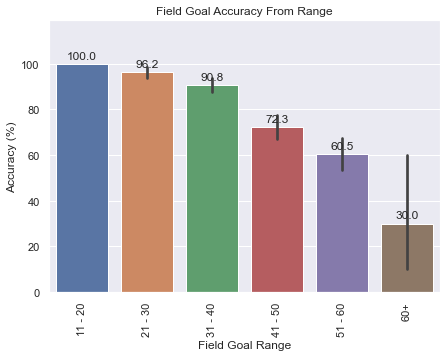

In [29]:
plt.figure(figsize = (7, 5))

plots = sns.barplot(x = 'kick_distance_range', y = 'fieldGoalPercentage', data = fg_perc_adv_df)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.1f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha = 'center', va = 'center',
                  size = 12, xytext = (0, 8),
                  textcoords = 'offset points')

plt.ylabel('Accuracy (%)')
plt.xlabel('Field Goal Range')
plt.xticks(rotation = 90)
plt.ylim(0, 119)
plt.title('Field Goal Accuracy From Range')

In [30]:
fg_only = ['Field Goal']
fg_only_df = kicker_fg_df[kicker_fg_df['specialTeamsPlayType'].isin(fg_only)]
#fg_only_df.head()
#fg_only_df.info()
fg_only_df['specialTeamsResult'].value_counts()

Kick Attempt Good       2212
Kick Attempt No Good     384
Blocked Kick Attempt      37
Out of Bounds              1
Downed                     1
Name: specialTeamsResult, dtype: int64

Text(0.5, 1.0, 'Made Field Goal Distances')

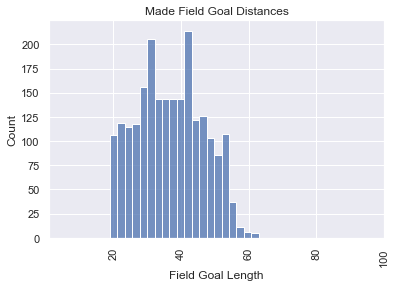

In [31]:
made_field_goal_df = fg_only_df.loc[fg_only_df['specialTeamsResult'] == 'Kick Attempt Good']

plt.figure(figsize = (6, 4))
sns.histplot(x = 'field_goal_distance', data = made_field_goal_df)

plt.ylabel('Count')
plt.xlabel('Field Goal Length')
plt.xticks(rotation = 90)
plt.xlim(1, 100)
plt.title('Made Field Goal Distances')

Text(0.5, 1.0, 'Missed Field Goal Distances')

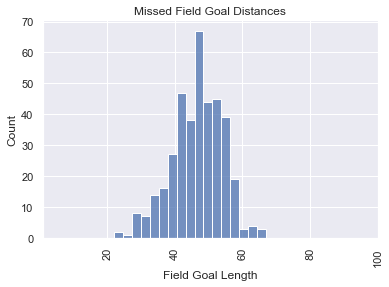

In [32]:
missed_field_goal_df = fg_only_df.loc[fg_only_df['specialTeamsResult'] == 'Kick Attempt No Good']

plt.figure(figsize = (6, 4))
sns.histplot(x = 'field_goal_distance', data = missed_field_goal_df)

plt.ylabel('Count')
plt.xlabel('Field Goal Length')
plt.xticks(rotation = 90)
plt.xlim(1, 100)
plt.title('Missed Field Goal Distances')

Text(0.5, 1.0, 'Blocked Field Goal Distances')

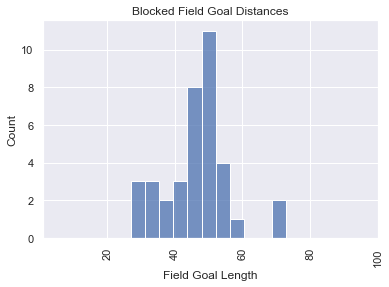

In [33]:
blocked_field_goal_df = fg_only_df.loc[fg_only_df['specialTeamsResult'] == 'Blocked Kick Attempt']

plt.figure(figsize = (6, 4))
sns.histplot(x = 'field_goal_distance', data = blocked_field_goal_df)

plt.ylabel('Count')
plt.xlabel('Field Goal Length')
plt.xticks(rotation = 90)
plt.xlim(1, 100)
plt.title('Blocked Field Goal Distances')

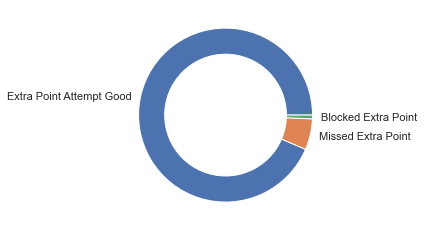

In [34]:
ep_only_df = ep_only_df['specialTeamsResult'].value_counts().reset_index()
ep_only_df.columns = ['specialTeamsResult', 'resultCount']

#ep_only_df.head()

pie_labels = ['Extra Point Attempt Good', 'Missed Extra Point', 'Blocked Extra Point']
plt.pie(ep_only_df['resultCount'], labels = pie_labels)
my_circle = plt.Circle((0, 0), 0.7, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

Text(0.5, 1.0, 'Extra Point Attempts')

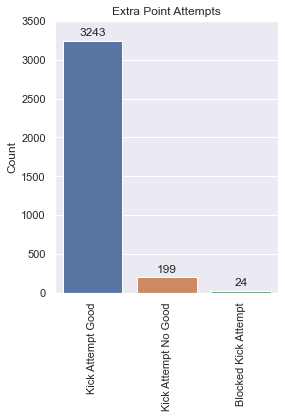

In [35]:
plt.figure(figsize = (4, 5))
plots = sns.barplot(x = 'specialTeamsResult', y = 'resultCount', data = ep_only_df)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.0f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha = 'center', va = 'center',
                  size = 12, xytext = (0, 8),
                  textcoords = 'offset points')

plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation = 90)
plt.ylim(0,3500)
plt.title('Extra Point Attempts')

In [36]:
###########################################################################################
##                                  KICK OFF DATA                                        ##
###########################################################################################

In [37]:
kickers = ['K']
kick_off_df = player_df[player_df['Position'].isin(kickers)]

#kick_off_df['Position'].value_counts()

In [38]:
kick_off_df = pd.merge(kick_off_df, play_df, left_on = 'nflId', right_on = 'kickerId', how = 'inner')
#kick_off_df['specialTeamsPlayType'].value_counts()

kickoff = ['Kickoff']
kick_off_df = kick_off_df[kick_off_df['specialTeamsPlayType'].isin(kickoff)]

In [39]:
kickoff_outcome = ['Touchback', 'Return']
kick_off_df = kick_off_df[kick_off_df['specialTeamsResult'].isin(kickoff_outcome)]

In [40]:
kick_off_df['specialTeamsResult'].value_counts()

Touchback    3924
Return       2316
Name: specialTeamsResult, dtype: int64

In [41]:
def touchback_outcome(row):
    if row['specialTeamsResult'] == 'Touchback' :
        return 1
    else :
        return 0
    
def return_outcome(row):
    if row['specialTeamsResult'] == 'Return' :
        return 1
    else :
        return 0
    
kick_off_df['touchback_outcome'] = kick_off_df.apply(lambda row: touchback_outcome(row), axis = 1)
kick_off_df['return_outcome'] = kick_off_df.apply(lambda row: return_outcome(row), axis = 1)

In [42]:
#create new dataframe and group by kicker, count of touchbacks and returned kicks
ko_outcome_df = kick_off_df.groupby(['nflId', 'displayName'])[['touchback_outcome', 'return_outcome']].sum().reset_index()
ko_outcome_df.columns = ['nflId', 'displayName', 'touchbacks', 'returns']
#ko_outcome_df.head()

In [43]:
ko_outcome_df['total_kicks'] = (ko_outcome_df.touchbacks + ko_outcome_df.returns)
#ko_outcome_distance_df.head()

avg_kick_offs = sum(ko_outcome_df.total_kicks) / len(ko_outcome_df.total_kicks)
ko_outcome_df1 = ko_outcome_df[(ko_outcome_df.total_kicks >= avg_kick_offs)]

print('Average number of kickoffs: ', round(avg_kick_offs, 2))

Average number of kickoffs:  115.56


In [44]:
ko_outcome_df1 = ko_outcome_df1.sort_values(by = ['total_kicks'], ascending = False).reset_index(drop = True)
ko_outcome_df1.head()

,nflId,displayName,touchbacks,returns,total_kicks
0,39470,Justin Tucker,180,110,290
1,45046,Harrison Butker,198,87,285
2,43689,Wil Lutz,207,77,284
3,41175,Jason Myers,169,82,251
4,43846,Ka'imi Fairbairn,151,96,247


Text(0.5, 1.0, 'Kick Offs - Touchbacks & Returns')

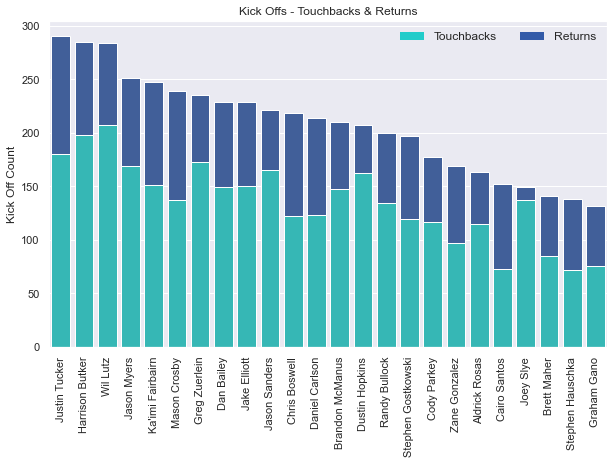

In [45]:
plt.figure(figsize = (10, 6))

bar1 = sns.barplot(x = 'displayName', y = 'total_kicks', data = ko_outcome_df1, color = '#325aa8')
bar2 = sns.barplot(x = 'displayName', y = 'touchbacks', data = ko_outcome_df1, color = '#21ccca')

topbar = plt.Rectangle((0,0),1,1,fc= '#325aa8', edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc= '#21ccca',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Touchbacks', 'Returns'], loc=1, ncol = 2, prop={'size':12})
l.draw_frame(False)



plt.ylabel('Kick Off Count')
plt.xlabel('')
plt.xticks(rotation = 90)
#plt.ylim(0,3500)
plt.title('Kick Offs - Touchbacks & Returns')

In [46]:
kickoff_distance_df = kick_off_df.groupby(['nflId', 'displayName']).agg({'playId' : 'count', 'kickLength' : 'mean'}).reset_index()
kickoff_distance_df.columns = ['nflId', 'displayName', 'totalKicks','avgKickLength']
kickoff_distance_df = kickoff_distance_df.sort_values(by = ['avgKickLength'], ascending = False).reset_index(drop = True)
kickoff_distance_df1 = kickoff_distance_df[(kickoff_distance_df.totalKicks >= avg_kick_offs)]
kickoff_distance_df1.head()

,nflId,displayName,totalKicks,avgKickLength
2,48337,Joey Slye,149,71.885906
6,43689,Wil Lutz,284,69.996479
7,38701,Greg Zuerlein,235,69.863830
9,45046,Harrison Butker,285,69.635088
10,41688,Cody Parkey,177,69.016949


Text(0.5, 1.0, 'Average Kick Off Distance')

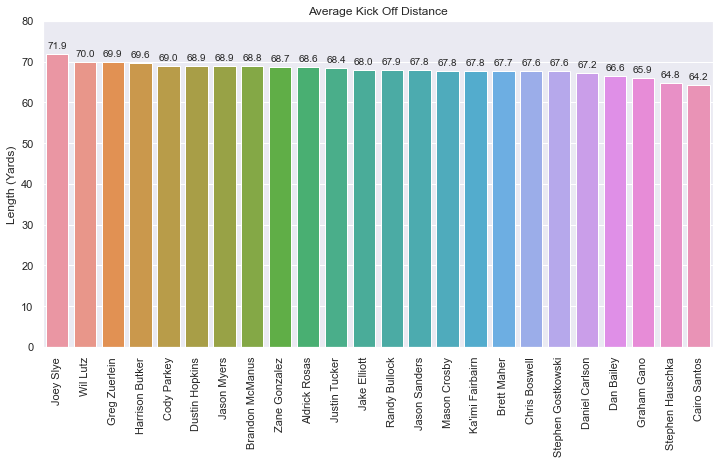

In [47]:
plt.figure(figsize = (12, 6))

plots = sns.barplot(x = 'displayName', y = 'avgKickLength', data = kickoff_distance_df1)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(),'.1f'),
                  (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha = 'center', va = 'center',
                  size = 10, xytext = (0, 8),
                  textcoords = 'offset points')

plt.ylabel('Length (Yards)')
plt.xlabel('')
plt.xticks(rotation = 90)
plt.ylim(0,80)
plt.title('Average Kick Off Distance')

In [48]:
###########################################################################################
##                                    PUNT DATA                                          ##
###########################################################################################

In [49]:
punters = ['P']
punter_df = player_df[player_df['Position'].isin(punters)]
punter_df['Position'].value_counts()

P    51
Name: Position, dtype: int64

In [50]:
punter_df = pd.merge(punter_df, play_df, left_on = 'nflId', right_on = 'kickerId', how = 'inner')

In [51]:
punt = ['Punt']
punter_df = punter_df[punter_df['specialTeamsPlayType'].isin(punt)]
punter_df['specialTeamsPlayType'].value_counts()

Punt    5910
Name: specialTeamsPlayType, dtype: int64

In [52]:
#create new dataframe and group by punter, count total punts and distances
punt_length_df = punter_df.groupby(['nflId', 'displayName']).agg({'playId' : 'size', 'kickLength' : 'mean'}).rename(columns = {'playId' : 'puntCount', 'kickLength' : 'avgPuntLength'}).reset_index()
#punt_length_df.head()
#punt_length_df.info()

In [53]:
avg_punt_count = sum(punt_length_df.puntCount) / len(punt_length_df.puntCount)
avg_punt_count = round(avg_punt_count, 2)
print('Average number of punts: ', avg_punt_count)

Average number of punts:  120.61


In [54]:
punt_length_df1 = punt_length_df[(punt_length_df.puntCount >= avg_punt_count)]
punt_length_df1.shape

punt_length_df1 = punt_length_df1.sort_values(by = ['puntCount'], ascending = False).reset_index(drop = True)

(30.0, 50.0)

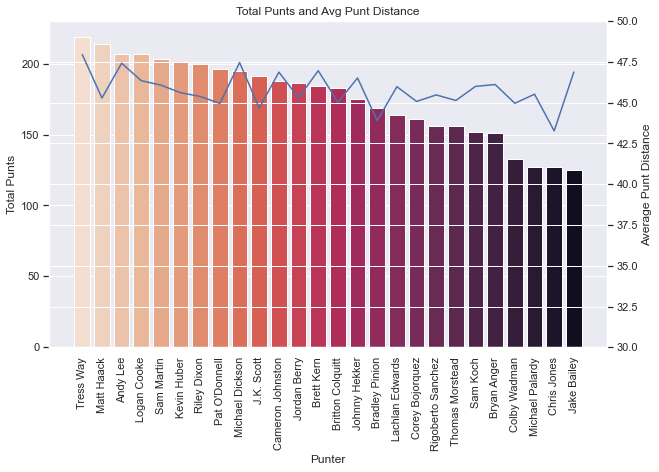

In [55]:
#Create combo chart (punts = bars, avg_distance = line)
fig, ax1 = plt.subplots(figsize=(10,6))

#bar
ax1 = sns.barplot(x = 'displayName', y = 'puntCount', data = punt_length_df1, palette = 'rocket_r')
ax1.set_title('Total Punts and Avg Punt Distance')
ax1.set_xlabel('Punter')
ax1.set_ylabel('Total Punts')
plt.xticks(rotation = 90)

ax2 = ax1.twinx() #secondary axis for line

#line
ax2 = sns.lineplot(x= 'displayName', y = 'avgPuntLength', data = punt_length_df1, sort = False)
ax2.set_ylabel('Average Punt Distance')
ax2.set_ylim(bottom = 30, top = 50)

Text(0.5, 1.0, 'Punt Distances')

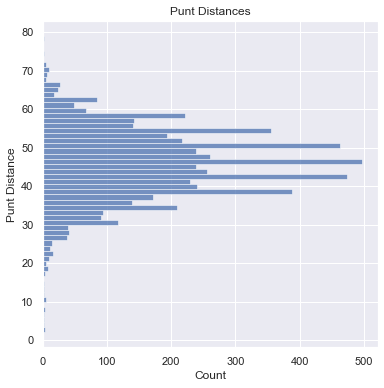

In [56]:
plt.figure(figsize = (6, 6))
sns.histplot(y = 'kickLength', data = punter_df)

plt.xlabel('Count')
plt.ylabel('Punt Distance')
#plt.xticks(rotation = 90)
#plt.ylim(1, 80)
plt.title('Punt Distances')

In [57]:
kick_adv_data = 'PFFScoutingData.csv'
kick_adv_df = pd.read_csv(kick_adv_data)
#kick_adv_df.head()

punter_adv_df = pd.merge(punter_df, kick_adv_df, on = ['playId', 'gameId'])
#punter_adv_df.head()

In [58]:
def punt_direction_key(row):
    if row['kickDirectionActual'] == 'L' :
        return 1
    if row['kickDirectionActual'] == 'C' :
        return 2
    if row['kickDirectionActual'] == 'R' :
        return 3

    
punter_adv_df['punt_direction_key'] = punter_adv_df.apply(lambda row: punt_direction_key(row), axis = 1)

Text(0.5, 1.0, 'Punt Direction')

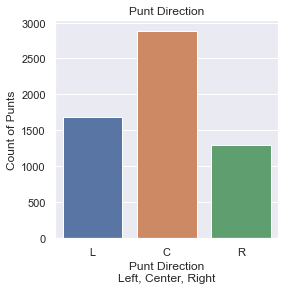

In [59]:
punt_direction_df = punter_adv_df.groupby(['punt_direction_key', 'kickDirectionActual']).size().reset_index()
punt_direction_df.columns = ['directionKey', 'directionActual', 'directionCount']
#punt_direction_df.head()

plt.figure(figsize = (4, 4))

sns.barplot(x = 'directionActual', y = 'directionCount', data = punt_direction_df)


plt.xlabel('Punt Direction\nLeft, Center, Right')
plt.ylabel('Count of Punts')
#plt.xticks(rotation = 90)
#plt.ylim(1, 80)
plt.title('Punt Direction')

In [60]:
#punter_adv_df.info()
punter_adv_df['specialTeamsResult'].value_counts()

Return           2282
Fair Catch       1640
Downed            827
Out of Bounds     585
Touchback         383
Muffed            154
Blocked Punt       39
Name: specialTeamsResult, dtype: int64

In [61]:
punt_length_direction_df = punter_adv_df

#punt_length_direction_df['specialTeamsResult'].value_counts()
def returned(row):
    if row['specialTeamsResult'] == 'Return' :
        return 'Yes'
    if row['specialTeamsResult'] == 'Fair Catch' :
        return 'No'
    if row['specialTeamsResult'] == 'Downed' :
        return 'No'
    if row['specialTeamsResult'] == 'Out of Bounds' :
        return 'No'
    if row['specialTeamsResult'] == 'Touchback' :
        return 'No'
    if row['specialTeamsResult'] == 'Muffed' :
        return 'Yes'


punt_length_direction_df['returned'] = punt_length_direction_df.apply(lambda row: returned(row), axis = 1)

punt_length_direction_df = punter_adv_df.loc[punter_adv_df['specialTeamsResult'] != 'Blocked Punt']

Text(0.5, 1.0, 'Punt Direction & Distances')

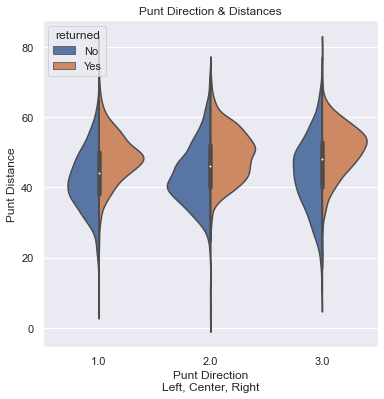

In [62]:
#punt_length_direction_df = punter_adv_df.loc[punter_adv_df['specialTeamsResult'] != 'Blocked Punt']

plt.figure(figsize = (6, 6))
#sns.jointplot(x = 'directionActual', y = 'kickLength', kind = 'hist', bins = 6, data = punt_length_direction_df)
sns.violinplot(data = punter_adv_df, x = 'punt_direction_key', y = 'kickLength', split = True, hue = 'returned')


plt.xlabel('Punt Direction\nLeft, Center, Right')
plt.ylabel('Punt Distance')
#plt.xticks(rotation = 90)
#plt.xlim(1, 3)
plt.title('Punt Direction & Distances')

Text(0.5, 1.0, 'Punt Direction')

<Figure size 288x288 with 0 Axes>

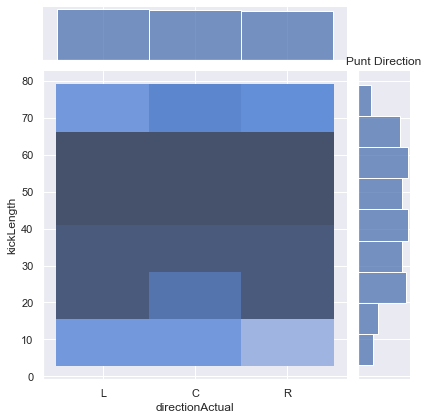

In [63]:
punt_direction_df = punter_adv_df.groupby(['punt_direction_key', 'kickDirectionActual', 'kickLength']).size().reset_index()
punt_direction_df.columns = ['directionKey', 'directionActual', 'kickLength','directionCount']
#punt_direction_df.head()

plt.figure(figsize = (4, 4))

sns.jointplot(x = 'directionActual', y = 'kickLength', data = punt_direction_df, kind = 'hist', bins = 6)


plt.xlabel('Punt Direction\nLeft, Center, Right')
plt.ylabel('Count of Punts')
#plt.xticks(rotation = 90)
#plt.ylim(1, 80)
plt.title('Punt Direction')